# Part II: Optimizing biophysical models

In this section of the tutorial, you will learn how to train biophysical models in `Jaxley`. This includes the following:

- compute the gradient with respect to parameters  
- use parameter transformations  
- define optimizers  
- write dataloaders and parallelize across data  

Let's get started!

In [ ]:
# !pip install optax

In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
from jax.nn import relu

import jaxley as jx
from jaxley.channels import Leak
from jaxley.synapses import DynamicSynapse
from jaxley.connect import connect
import pandas as pd

We will first define a network similar to how we showed previously:

In [3]:
import pyarrow.feather as feather

nodes = feather.read_table("malecns_optic_lobe_hex_08_malecns_09_optic_lobe_hex_08_meta.feather")
nodes = nodes.to_pandas()
edges = feather.read_table("malecns_optic_lobe_hex_08_malecns_09_optic_lobe_hex_08_simple_edgelist.feather")
edges = edges.to_pandas()

id_to_idx = pd.Series(nodes.index.to_numpy(), index=nodes["malecns_09_id"])
id_to_idx.index = id_to_idx.index.astype(edges["pre"].dtype, copy=False)

edges["pre"] = edges["pre"].map(id_to_idx)
edges["post"] = edges["post"].map(id_to_idx)

excitatory = nodes.query("neurotransmitter_predicted == 'acetylcholine'").index.to_numpy()
inhibitory = nodes.query("neurotransmitter_predicted == 'glutamate'").index.to_numpy()
unknown = nodes.query("neurotransmitter_predicted == 'unclear'").index.to_numpy()
t4 = nodes.query("cell_type in ['T4a', 'T4b', 'T4c', 'T4d']").index.to_numpy()
photoreceptors = nodes.query("cell_type in ['R1-R6', 'R8_unclear', 'R7_unclear', 'R8y', 'R7y', 'R7p']").index.to_numpy()

In [4]:
point_neuron = jx.Cell()
num_cells = len(nodes)
net = jx.Network([point_neuron for _ in range(num_cells)])

In [5]:
net.cell(excitatory).add_to_group("excitatory")
net.cell(inhibitory).add_to_group("inhibitory")
net.cell(unknown).add_to_group("unkonwn")
net.cell(t4).add_to_group("t4")
net.cell(photoreceptors).add_to_group("photoreceptors")

In [6]:
pre_cells = net.select(nodes=edges["pre"].to_numpy())
post_cells = net.select(nodes=edges["post"].to_numpy())
connect(pre_cells, post_cells, DynamicSynapse())

net.excitatory.set("DynamicSynapse_e_syn", 0.0)
net.inhibitory.set("DynamicSynapse_e_syn", -75.0)
net.unkonwn.set("DynamicSynapse_e_syn", -10.0)

Added 36 recordings. See `.recordings` for details.
Added 46 external_states. See `.externals` for details.


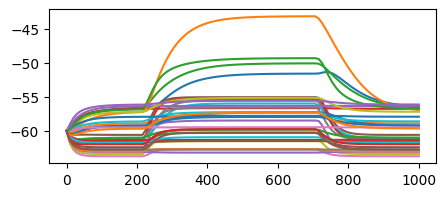

In [9]:
net.insert(Leak())

### RECORDINGS.
net.delete_recordings()
net.t4.record()

### STIMULI.
i_delay = 200.0
i_dur = 500.0
dt = 10.0
t_max = 1_000.0
_ = np.random.seed(0)
i_amps = np.random.rand(len(photoreceptors)) * 0.01
stimuli = jx.datapoint_to_step_currents(i_delay, i_dur, i_amps, dt, t_max)

net.delete_stimuli()
net.photoreceptors.stimulate(stimuli)

num_synapses = len(net.edges)
_ = np.random.seed(0)
net.set("DynamicSynapse_s", 0.0)

syn_strenghts = np.random.rand(num_synapses) * 2e-5 + 5e-6
net.DynamicSynapse.edge("all").set("DynamicSynapse_gS", syn_strenghts)
net.set("DynamicSynapse_v_th", -30.0)

input_resistances = np.random.randn(num_cells) * 500.0 + 10_000
net.set("Leak_gLeak", 1 / input_resistances)
net.set("Leak_eLeak", -65.0)
net.set("v", -60.0)

v = jx.integrate(net, delta_t=dt)
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
t = np.linspace(0, t_max, v.shape[1])
_ = ax.plot(t, v.T)
plt.show()

In [10]:
import pickle
with open("optic_lobe_v_recordings.pkl", "wb") as handle:
    pickle.dump(v, handle)
    
with open("optic_lobe_input_resistances.pkl", "wb") as handle:
    pickle.dump(input_resistances, handle)
    
with open("optic_lobe_syn_strenghts.pkl", "wb") as handle:
    pickle.dump(syn_strenghts, handle)